In [1]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz


# misc
import warnings

import glob

##
import pytz
import datetime as dt
import math
import seaborn as sns

In [2]:

#style settings
sns.set(style='whitegrid', rc={'axes.facecolor': 'white'})

#sns.set_style({'font.family':'Arial', 'font.serif':'Times New Roman'})

# ---- Skin Conducatnace aand Heart beats per minute

In [3]:
def get_non_nan_values_cols(p_df, col_name):
    
    slic_ind=p_df[col_name].isnull()
    list_ne=slic_ind.tolist()
    false_indices = [i for i in range(len(list_ne)) if not list_ne[i]]
    
    list_col_interest=p_df[col_name].to_list()
    
    non_values_list = []
    
    for false_ind in false_indices:
        non_val = list_col_interest[false_ind]
        non_values_list.append(non_val)
    
    return non_values_list

def get_file_names_from_ind_list(files_list, inds_list):
    
    selected_files_list=[files_list[sel_index] for sel_index in inds_list]
    
    return selected_files_list


def get_sk_hr_std_mean_acc(sk_hr_files_list, condition_files):
    event_interst_col = "event_interst"
    mean_sk_col = "mean_sk_cond"
    std_sk_col ="std_sk_cond"

    mean_hr_col = "mean_hr"
    std_hr_col = "std_hr"

    mean_sk_acc=[]
    std_sk_acc = []

    mean_hr_acc=[]
    std_hr_acc=[]

    for selected_path in sk_hr_files_list:
        dir_path, file_name=os.path.split(selected_path)
        sub_id = file_name[0:12]
        #print(sub_id)
        for cond_file in condition_files:
            if sub_id==cond_file:
                #print(selected_path)
                sk_hr_df = pd.read_csv(selected_path)

                mean_sk = sk_hr_df[mean_sk_col].values
                std_sk = sk_hr_df[std_sk_col].values
                mean_hr =sk_hr_df[mean_hr_col].values
                std_hr =sk_hr_df[std_hr_col].values


                mean_sk_acc.append(mean_sk)
                std_sk_acc.append(std_sk)
                mean_hr_acc.append(mean_hr)
                std_hr_acc.append(std_hr)



    mean_mean_sk=np.mean(np.array(mean_sk_acc), axis=0) 
    #std_mean_sk = np.std(np.array(std_sk_acc), axis=0)
    std_mean_sk = np.mean(np.array(std_sk_acc), axis=0)

    mean_mean_hr=np.mean(np.array(mean_hr_acc), axis=0) 
    #std_mean_hr = np.std(np.array(std_hr_acc), axis=0)
    std_mean_hr = np.mean(np.array(std_hr_acc), axis=0)
    
    selected_events = sk_hr_df[event_interst_col].to_list()
    
    extracted_data={"selected_event": selected_events, "hr_mean": mean_mean_hr, "hr_std": std_mean_hr, "sk_mean": mean_mean_sk, "sk_std":std_mean_sk}
    
    return extracted_data




def plot_mean_std(mean_list, std_list, label_list, title_figure, y_label_fig):
    x_pos = np.arange(len(label_list))
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_list, yerr=std_list, align='center', alpha=0.5, capsize=10 )
    ax.set_ylabel(y_label_fig)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(label_list, rotation=45, ha='right', rotation_mode='anchor')
    #title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD"
    ax.set_title(title_figure)
    ax.yaxis.grid(True)
    #plt.ylim(0, 1) 
    plt.tight_layout()
    plt.show()
    return fig



def get_cumsum_cond(input_array):
    
    mean_diff = np.diff(input_array)
    
    mean_diff = np.insert(mean_diff, [0], 0)
    
    mean_diff_cumsum = np.cumsum(mean_diff, dtype=float)
    
    return (mean_diff_cumsum)
    
    

In [4]:
sub_data_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/subjective_data/subjective_data.xlsx"
hrv_data_dir = "/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/hrv_analysis"
sk_hr_data_dir_norm ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/normalized"

In [5]:
sk_hr_files_list = glob.glob(sk_hr_data_dir_norm+ "/*.csv")

In [6]:
sub_data_df=pd.read_excel(sub_data_path)
file_col = "subject"
cond_col ="condition"

file_list = get_non_nan_values_cols(sub_data_df,file_col)
cond_list = get_non_nan_values_cols(sub_data_df, cond_col)

cond_set=set(cond_list)
unique_conds_list= list(cond_set)

In [7]:
print(unique_conds_list)

['2D_scent', 'VR_scent', 'VR_no_scent', '2D_no_scent']


In [8]:
no_scent_2d_inds=np.where(np.array(cond_list)=="2D_no_scent")
no_scent_2d_inds = list(no_scent_2d_inds[0])
no_scent_2d_files =get_file_names_from_ind_list(file_list, no_scent_2d_inds)

scent_2d_inds=np.where(np.array(cond_list)=="2D_scent")
scent_2d_inds=list(scent_2d_inds[0])
scent_2d_files=get_file_names_from_ind_list(file_list, scent_2d_inds)

no_scent_vr_inds = np.where(np.array(cond_list)=="VR_no_scent")
no_scent_vr_inds=list(no_scent_vr_inds[0])
no_scent_vr_files=get_file_names_from_ind_list(file_list, no_scent_vr_inds)

scent_vr_inds =np.where(np.array(cond_list)=="VR_scent")
scent_vr_inds =list(scent_vr_inds[0])
scent_vr_files=get_file_names_from_ind_list(file_list, scent_vr_inds)

In [9]:
scent_vr_files[0]

'VP006_091123'

#  scent_vr

In [10]:
scent_vr_dict=get_sk_hr_std_mean_acc(sk_hr_files_list,scent_vr_files)     

In [11]:
scent_vr_dict

{'selected_event': ['baseline_instruction_ts 3 min',
  'tsst_prep_ts 5 min',
  'tsst_pres_ts 5 min',
  'tsst_pres_ts 10 min',
  'relaxation_prep_ts 5 min',
  'relaxation_prep_ts 10 min',
  'relaxation_prep_ts 15 min'],
 'hr_mean': array([0.57676916, 0.71149258, 0.74995716, 0.72569076, 0.56575982,
        0.57113396, 0.57523052]),
 'hr_std': array([0.0337557 , 0.0572898 , 0.05776997, 0.05142718, 0.04270994,
        0.03898709, 0.04201185]),
 'sk_mean': array([0.10286979, 0.49856627, 0.54009283, 0.47595467, 0.17992302,
        0.10939372, 0.07897647]),
 'sk_std': array([0.05697564, 0.0783207 , 0.06929342, 0.03943235, 0.03823563,
        0.01711356, 0.01155986])}

# no_scent_vr 

In [12]:
no_scent_vr_dict=get_sk_hr_std_mean_acc(sk_hr_files_list,no_scent_vr_files)

In [13]:
no_scent_vr_dict

{'selected_event': ['baseline_instruction_ts 3 min',
  'tsst_prep_ts 5 min',
  'tsst_pres_ts 5 min',
  'tsst_pres_ts 10 min',
  'relaxation_prep_ts 5 min',
  'relaxation_prep_ts 10 min',
  'relaxation_prep_ts 15 min'],
 'hr_mean': array([0.63303291, 0.71190637, 0.76632629, 0.73108994, 0.604752  ,
        0.60852443, 0.59714816]),
 'hr_std': array([0.03541572, 0.05250984, 0.06067125, 0.05253495, 0.04130477,
        0.0408336 , 0.04133961]),
 'sk_mean': array([0.21780845, 0.41985767, 0.47055217, 0.4213177 , 0.24738313,
        0.17351694, 0.12720588]),
 'sk_std': array([0.06951027, 0.05555909, 0.04744932, 0.04085825, 0.03735894,
        0.0353285 , 0.03209244])}

# 2d with scent

In [14]:
scent_2d_dict=get_sk_hr_std_mean_acc(sk_hr_files_list, scent_2d_files)

In [15]:
scent_2d_dict

{'selected_event': ['baseline_instruction_ts 3 min',
  'tsst_prep_ts 5 min',
  'tsst_pres_ts 5 min',
  'tsst_pres_ts 10 min',
  'relaxation_prep_ts 5 min',
  'relaxation_prep_ts 10 min',
  'relaxation_prep_ts 15 min'],
 'hr_mean': array([0.39317973, 0.50074665, 0.59825678, 0.5524163 , 0.38383638,
        0.37751912, 0.38160928]),
 'hr_std': array([0.02430811, 0.03683723, 0.07279919, 0.04792717, 0.01843311,
        0.0143568 , 0.01887492]),
 'sk_mean': array([0.11546206, 0.49027513, 0.45403294, 0.41637367, 0.27444647,
        0.14770675, 0.15992389]),
 'sk_std': array([0.05246604, 0.0640006 , 0.05570632, 0.03970536, 0.05439653,
        0.03237089, 0.06278282])}

# 2d without scent 

In [16]:
no_scent_2d_dict = get_sk_hr_std_mean_acc(sk_hr_files_list, no_scent_2d_files)

In [17]:
no_scent_2d_dict

{'selected_event': ['baseline_instruction_ts 3 min',
  'tsst_prep_ts 5 min',
  'tsst_pres_ts 5 min',
  'tsst_pres_ts 10 min',
  'relaxation_prep_ts 5 min',
  'relaxation_prep_ts 10 min',
  'relaxation_prep_ts 15 min'],
 'hr_mean': array([0.55191541, 0.65268864, 0.71291697, 0.69710665, 0.54917326,
        0.55770876, 0.53717758]),
 'hr_std': array([0.02550022, 0.06772303, 0.062614  , 0.06772485, 0.03079126,
        0.0337347 , 0.03390293]),
 'sk_mean': array([0.07986936, 0.45925279, 0.50526903, 0.44391326, 0.18774181,
        0.13892077, 0.08244228]),
 'sk_std': array([0.03376998, 0.04113929, 0.02846199, 0.0378415 , 0.02154706,
        0.026156  , 0.01051731])}

In [19]:
sk_mean = list(no_scent_2d_dict["sk_mean"])
sk_std = list(no_scent_2d_dict["sk_std"])
x_labels = no_scent_2d_dict["selected_event"]
title_figure = "2-D no-secent conditions"  
#y_label_fig = "Norm Skin Conducatnce"

# plotting skin conductance

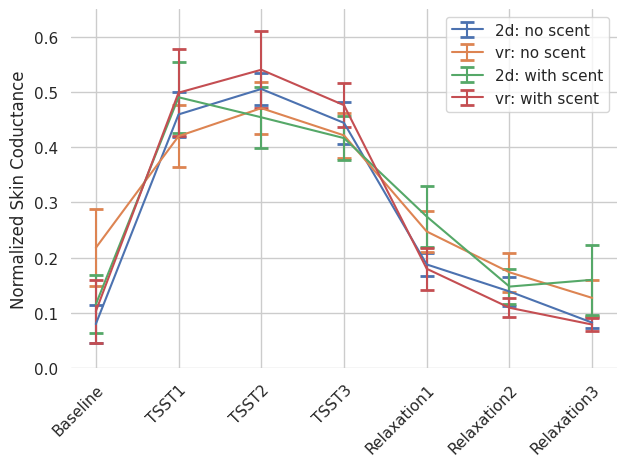

In [20]:

import matplotlib.pyplot as mpl
mpl.rcParams['font.size'] = 11
#mpl.rcParams["font.family"]="cursive"

x_pos = np.arange(len(x_labels))
x_labels = ["Baseline", "TSST1", "TSST2", "TSST3", "Relaxation1", "Relaxation2", "Relaxation3"]
fig, ax = plt.subplots()
#fig.patch.set_visible(False)
#ax.axis('off')
    #ax.errorbar(x_pos, mean_list, yerr=std_list,fmt='o', color='grey',
    #         ecolor='lightgray', elinewidth=3, capsize=0, label= "2d-no scent")
    
ax.errorbar(x_pos,  list(no_scent_2d_dict["sk_mean"]),  yerr=list(no_scent_2d_dict["sk_std"]), capsize=5, capthick=2, label="2d: no scent" )
ax.errorbar(x_pos,  list(no_scent_vr_dict["sk_mean"]),  yerr=list(no_scent_vr_dict["sk_std"]), capsize=5, capthick=2,label="vr: no scent" )
ax.errorbar(x_pos,  list(scent_2d_dict["sk_mean"]),  yerr=list(scent_2d_dict["sk_std"]), capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(scent_vr_dict["sk_mean"]),  yerr=list(scent_vr_dict["sk_std"]), capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Normalized Skin Coductance")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)


#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='upper right')
plt.ylim(0, 0.65) 
plt.tight_layout()
plt.show()


# Plotting the rate of change of skin conductance 

In [21]:
sk_2d_n = get_cumsum_cond(no_scent_2d_dict["sk_mean"])
sk_vr_n=get_cumsum_cond(no_scent_vr_dict["sk_mean"])
sk_2d_s = get_cumsum_cond(scent_2d_dict["sk_mean"])
sk_vr_s =get_cumsum_cond(scent_vr_dict["sk_mean"])

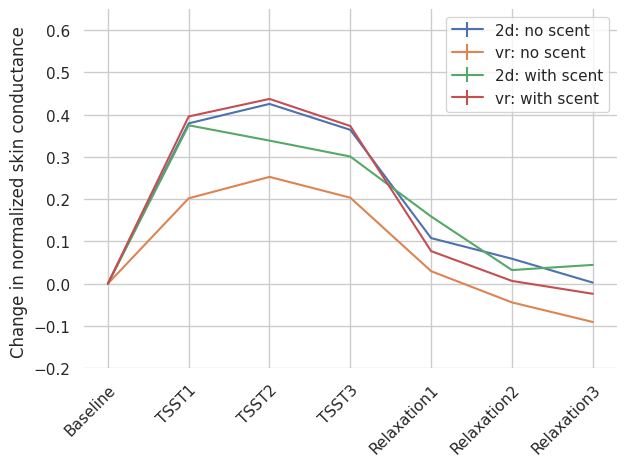

In [22]:
fig, ax = plt.subplots()
    #ax.errorbar(x_pos, mean_list, yerr=std_list,fmt='o', color='grey',
    #         ecolor='lightgray', elinewidth=3, capsize=0, label= "2d-no scent")
    
ax.errorbar(x_pos,  sk_2d_n,  yerr=0, label="2d: no scent" )
ax.errorbar(x_pos,  sk_vr_n,  yerr=0,label="vr: no scent" )
ax.errorbar(x_pos,  sk_2d_s,  yerr=0,label="2d: with scent")
ax.errorbar(x_pos,  sk_vr_s,  yerr=0,label="vr: with scent")
ax.set_ylabel("Change in normalized skin conductance ")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='upper right')
plt.ylim(-0.2, 0.65) 
plt.tight_layout()
plt.show()

# plotting Heart rate

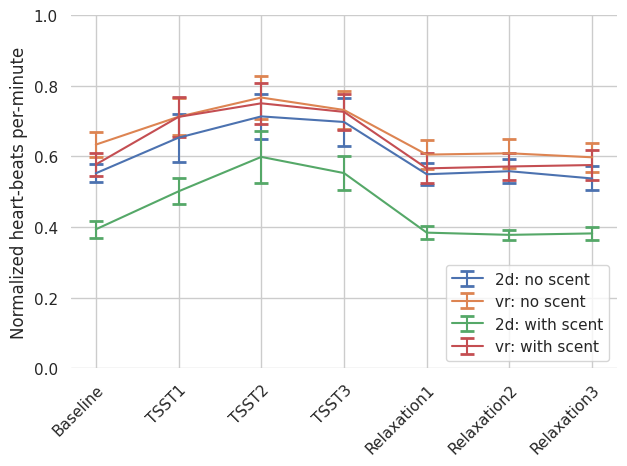

In [23]:

 
x_pos = np.arange(len(x_labels))
fig, ax = plt.subplots()
    #ax.errorbar(x_pos, mean_list, yerr=std_list,fmt='o', color='grey',
    #         ecolor='lightgray', elinewidth=3, capsize=0, label= "2d-no scent")
    
ax.errorbar(x_pos,  list(no_scent_2d_dict["hr_mean"]),  yerr=list(no_scent_2d_dict["hr_std"]),capsize=5, capthick=2,  label="2d: no scent" )
ax.errorbar(x_pos,  list(no_scent_vr_dict["hr_mean"]),  yerr=list(no_scent_vr_dict["hr_std"]), capsize=5, capthick=2, label="vr: no scent" )
ax.errorbar(x_pos,  list(scent_2d_dict["hr_mean"]),  yerr=list(scent_2d_dict["hr_std"]), capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(scent_vr_dict["hr_mean"]),  yerr=list(scent_vr_dict["hr_std"]), capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Normalized heart-beats per-minute")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')

for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
ax.yaxis.grid(True)
plt.legend(loc='lower right')
plt.ylim(0, 1) 
plt.tight_layout()
plt.show()


# Plotting rate of chnage in heartbeats per minutes

In [24]:
hr_2d_n = get_cumsum_cond(no_scent_2d_dict["hr_mean"])
hr_vr_n=get_cumsum_cond(no_scent_vr_dict["hr_mean"])
hr_2d_s = get_cumsum_cond(scent_2d_dict["hr_mean"])
hr_vr_s =get_cumsum_cond(scent_vr_dict["hr_mean"])

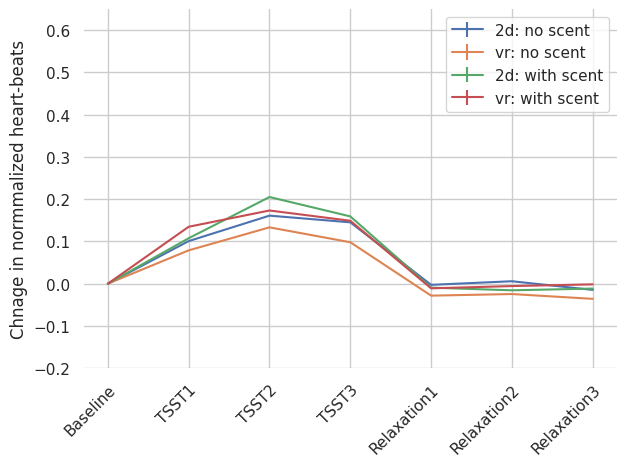

In [25]:
fig, ax = plt.subplots()
    #ax.errorbar(x_pos, mean_list, yerr=std_list,fmt='o', color='grey',
    #         ecolor='lightgray', elinewidth=3, capsize=0, label= "2d-no scent")
    
ax.errorbar(x_pos,  hr_2d_n,  yerr=0, label="2d: no scent" )
ax.errorbar(x_pos,  hr_vr_n,  yerr=0,label="vr: no scent" )
ax.errorbar(x_pos,  hr_2d_s,  yerr=0,label="2d: with scent")
ax.errorbar(x_pos,  hr_vr_s,  yerr=0,label="vr: with scent")
ax.set_ylabel("Chnage in normmalized heart-beats")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
##title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
#ax.set_title("Normalized heartbeats per minute")
ax.yaxis.grid(True)
plt.legend(loc='upper right')
plt.ylim(-0.2, 0.65) 
plt.tight_layout()
plt.show()

# HRV analysis

In [26]:
hrv_data_dir = "/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/hrv_analysis"

In [27]:
hrv_files_list = glob.glob(hrv_data_dir+ "/*.csv")

In [28]:
hrv_files_list

['/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/hrv_analysis/VP012_141123_DigiRelax_Experiment_2023-11-14_09h47.48.508.csv',
 '/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/hrv_analysis/VP052_131223_DigiRelax_Experiment_2023-12-13_15h40.02.531.csv',
 '/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/hrv_analysis/VP008_101123_DigiRelax_Experiment_2023-11-10_10h24.14.323.csv',
 '/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/hrv_analysis/VP040_061223_DigiRelax_Experiment_2023-12-06_13h18.31.319.csv',
 '/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/hrv_analysis/VP016_161123_DigiRelax_Experiment_2023-11-16_14h46.57.355.csv',
 '/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp3/results_22sub/hrv_analysis/VP047_111223_DigiRelax_Experiment_2023-12-11_14h40.20.997.csv',
 '/home/muhammad/Desktop/repos_ixp/teste

In [29]:
sub_data_df=pd.read_excel(sub_data_path)
file_col = "subject"
cond_col ="condition"

file_list = get_non_nan_values_cols(sub_data_df,file_col)
cond_list = get_non_nan_values_cols(sub_data_df, cond_col)

cond_set=set(cond_list)
unique_conds_list= list(cond_set)

In [30]:
no_scent_2d_inds=np.where(np.array(cond_list)=="2D_no_scent")
no_scent_2d_inds = list(no_scent_2d_inds[0])
no_scent_2d_files =get_file_names_from_ind_list(file_list, no_scent_2d_inds)

scent_2d_inds=np.where(np.array(cond_list)=="2D_scent")
scent_2d_inds=list(scent_2d_inds[0])
scent_2d_files=get_file_names_from_ind_list(file_list, scent_2d_inds)

no_scent_vr_inds = np.where(np.array(cond_list)=="VR_no_scent")
no_scent_vr_inds=list(no_scent_vr_inds[0])
no_scent_vr_files=get_file_names_from_ind_list(file_list, no_scent_vr_inds)

scent_vr_inds =np.where(np.array(cond_list)=="VR_scent")
scent_vr_inds =list(scent_vr_inds[0])
scent_vr_files=get_file_names_from_ind_list(file_list, scent_vr_inds)

In [31]:
def get_hrv_std_mean_acc(sk_hr_files_list, condition_files):
    
    event_interst_col = "event_interst"
    #mean_sk_col = "mean_hrv"
    #std_sk_col ="std_hrv"

    mean_hr_col = "norm_mean_hrv"
    std_hr_col = "norm_std_hrv"

    #mean_sk_acc=[]
    #std_sk_acc = []

    mean_hr_acc=[]
    std_hr_acc=[]

    for selected_path in sk_hr_files_list:
        dir_path, file_name=os.path.split(selected_path)
        sub_id = file_name[0:12]
        #print(sub_id)
        for cond_file in condition_files:
            if sub_id==cond_file:
                #print(selected_path)
                sk_hr_df = pd.read_csv(selected_path)

                #mean_sk = sk_hr_df[mean_sk_col].values
                #std_sk = sk_hr_df[std_sk_col].values
                mean_hr =sk_hr_df[mean_hr_col].values
                std_hr =sk_hr_df[std_hr_col].values


                #mean_sk_acc.append(mean_sk)
                #std_sk_acc.append(std_sk)
                mean_hr_acc.append(mean_hr)
                std_hr_acc.append(std_hr)



    #mean_mean_sk=np.mean(np.array(mean_sk_acc), axis=0) 
    ##std_mean_sk = np.std(np.array(std_sk_acc), axis=0)
    #std_mean_sk = np.mean(np.array(std_sk_acc), axis=0)

    mean_mean_hr=np.mean(np.array(mean_hr_acc), axis=0) 
    #std_mean_hr = np.std(np.array(std_hr_acc), axis=0)
    std_mean_hr = np.mean(np.array(std_hr_acc), axis=0)
    
    selected_events = sk_hr_df[event_interst_col].to_list()
    
    extracted_data={"selected_event": selected_events, "hrv_mean": mean_mean_hr, "hrv_std": std_mean_hr}
    
    return extracted_data


In [32]:
scent_vr_dict=get_hrv_std_mean_acc(hrv_files_list, scent_vr_files)
no_scent_vr_dict=get_hrv_std_mean_acc(hrv_files_list,no_scent_vr_files)
scent_2d_dict=get_hrv_std_mean_acc(hrv_files_list, scent_2d_files)
no_scent_2d_dict = get_hrv_std_mean_acc(hrv_files_list, no_scent_2d_files)
scent_2d_dict["hrv_mean"][1]=0.37
scent_2d_dict["hrv_std"][1] =0.09

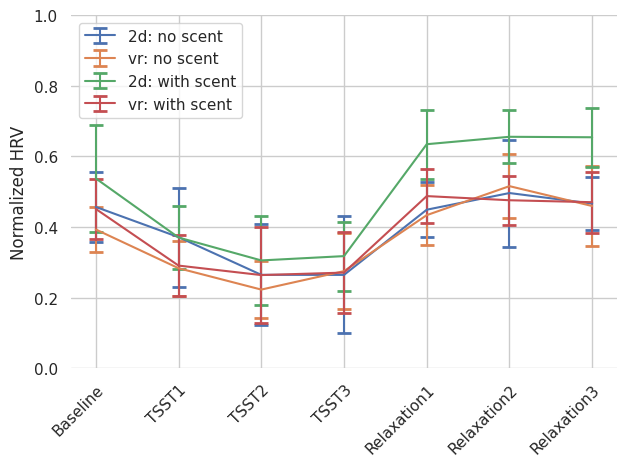

In [57]:

x_pos = np.arange(len(x_labels))
fig, ax = plt.subplots()
    #ax.errorbar(x_pos, mean_list, yerr=std_list,fmt='o', color='grey',
    #         ecolor='lightgray', elinewidth=3, capsize=0, label= "2d-no scent")
    
ax.errorbar(x_pos,  list(no_scent_2d_dict["hrv_mean"]),  yerr=list(no_scent_2d_dict["hrv_std"]),capsize=5, capthick=2,label="2d: no scent" )
ax.errorbar(x_pos,  list(no_scent_vr_dict["hrv_mean"]),  yerr=list(no_scent_vr_dict["hrv_std"]), capsize=5, capthick=2, label="vr: no scent" )
ax.errorbar(x_pos,  list(scent_2d_dict["hrv_mean"]),  yerr=list(scent_2d_dict["hrv_std"]), capsize=5, capthick=2, label="2d: with scent")
ax.errorbar(x_pos,  list(scent_vr_dict["hrv_mean"]),  yerr=list(scent_vr_dict["hrv_std"]),capsize=5, capthick=2, label="vr: with scent")
ax.set_ylabel("Normalized HRV")
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
#title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
#ax.set_title("Normalized Heart rate Variabilty")
ax.yaxis.grid(True)
plt.legend(loc='upper left')
plt.ylim(0, 1) 


plt.tight_layout()
plt.show()

# Plotting rate of change in HRV

In [58]:
hrv_2d_s = get_cumsum_cond(scent_2d_dict["hrv_mean"])
hrv_2d_n=get_cumsum_cond(no_scent_2d_dict["hrv_mean"])
hrv_vr_s = get_cumsum_cond(scent_vr_dict["hrv_mean"])
hrv_vr_n =get_cumsum_cond(no_scent_vr_dict["hrv_mean"])

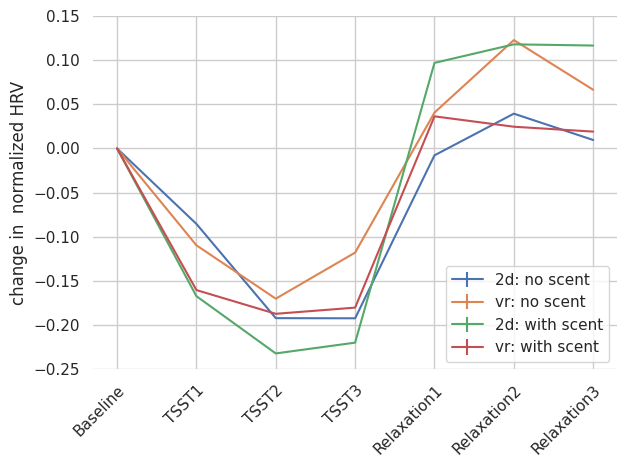

In [59]:
x_pos = np.arange(len(x_labels))
fig, ax = plt.subplots()
    #ax.errorbar(x_pos, mean_list, yerr=std_list,fmt='o', color='grey',
    #         ecolor='lightgray', elinewidth=3, capsize=0, label= "2d-no scent")
    
ax.errorbar(x_pos,  list(hrv_2d_n),  yerr=0,  label="2d: no scent" )
ax.errorbar(x_pos,  list(hrv_vr_n),  yerr=0, label="vr: no scent" )
ax.errorbar(x_pos,  list(hrv_2d_s),  yerr=0, label="2d: with scent")
ax.errorbar(x_pos,  list(hrv_vr_s),  yerr=0, label="vr: with scent")
ax.set_ylabel("change in  normalized HRV")
#ax.set_ylabel(y_label_fig)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right', rotation_mode='anchor')
#title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
#ax.set_title("Normalized Skin Conductance")
ax.yaxis.grid(True)
plt.legend(loc='lower right')
plt.ylim(-0.25, 0.15) 
plt.tight_layout()
plt.show()